<a href="https://colab.research.google.com/github/abernauer/Deep-Learning-with-Python/blob/master/Chapter3_Getting_started_with_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Chapter 3 Getting started with neural networks


#3.1 Anatomy of a neural networks 

Training a neural network revolves around the following objects:

* Layers which are combined into a network (or model)
* The input data and corresponding targets
* The loss function, which defines the feedback signal used for learning.
* The optimizer, which determines how learning proceeds.

Add diagram of the components and how they interact.

#3.1.1 Layers the building blocks of deep learning

The fundamental data structure in neural networks is the *layer*, to which you were introduced in chapter 2. A layer is a data-processing module that takes as input one or more tensors and that outputs one or more tensors. Some layers are stateless but more frequently layers have a state: the layer's *weights*, one or several tensors learned with stochastic gradient descent, which together contain the network's *knowledge*. 

Different layers are appropriate for different tensor formats and different types of data processing. For instance, simple vector data, stored in 2D tensors of shape (samples, features), is often processed by *densely connected* layers, also called *fully connected* or *dense* layers. Sequence data, stored in 3D tensors of shape (samples, timesteps, features), is typically processed by *recurrent* layers such as an *LSTM* layer.
Image data, stored in 4D tensor, is usually processed by 2D convolution layers.

A metaphor for layers is thinking of them as LEGO bricks for deep learning. Building deep-learning models in Keras is done by clipping together compatible layers to form useful data-transformation pipelines. The notion of layer *compatibility* here refers specifically to the fact that every layer will only accept input tensor of a certain shape and will return output tensors of a certain shape. Example: 

```
from keras import layers

layer = layers.Dense(32, input_shape=(784,))
```

We're creating a layer that will only accept as input 2D tensors where the first dimension is 784(axis 0, the batch dimension, is unspecified, and thus any value would be accepted.) This layer will return a tensor where the first dimension has been transformed to be 32.

Thus this layer can only be connected to a downstream layer that expects 32-dimensional vectors as its input. When using Keras, you don't have to worry about compatibility, because the layers you add to your models are dynamically built to match the shape of the incoming layer. For instance, suppose you write the following: 

```
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(32, input_shape=(784,)))
model.add(layers.Dense(32))
```

The second layer will automatically infer its input shape as being the the output shape of the layer that came before.

#3.1.2 Models: networks of layers

A deep-learning model is a directed, acyclic graph of layers. The most common instance is a linear stack of layers, mapping a single input to a single output.

Some broader networks include:

* Two-branch networks
* Multihead networks
* Inception blocks

The topology of a network defines a *hypothesis space*. You may remember that in chapter 1, we defined machine learning as "searching for useful representations of some input data, within a predefined space of possibilities, using guidance from a feedback signal". By choosing a network topology, you constrain your *space of possibilities* (hypothesis space) to a specific series of tensor operations, mapping input data to output data. What you'll then be searching for is a good set of values for the weight tensors involved in these tensor operations.

#3.1.3 Loss functions and optimizers: keys to configuring the learning process

Once the network architecture is defined, you still have to choose two more things:

* Loss function (objective function)-- The quantity that will be minimized during training. It represents a measure of success for the task at hand.
* Optimizer--Determines how the network will be updated based on the loss function. It implements a specific variant of stochastic gradient descent(SGD).

Choosing the right objective function for the right problem is extremely important: your network will take any shortcut it can, to minimize the loss; so if the objective doesn't fully correlate with success for the task at hand your network will end up doing things you may not have wanted. 

Guidelines for chosing the correct loss:
* binary crossentropy
  - two-class classification problem
* categorical crossentropy
  - many-class classification problem
* mean squared error
  - regression problems
* Connectionist temporal classification
  - sequence-learning problem

#3.2.2 Developing with Keras: a quick overview

The typical Keras workflow looks like this:

1. Define your training data: input tensors and target tensors.
2. Define a network of layers (or *model*) that maps your inputs to your targets.
3. Configure the learning process by choosing a loss function, an optimizer, and some metrics to monitor.
4. Iterate on your training data by calling the fit() method of your model.

There are two ways to define a model: using the *Sequential* class(only for linear stacks of layers, which is the most common architecture) or the *functional* API.

As a refresher, here's a two-layer model defined using the *Sequential* class (note that we're passing the expected shape of the input data to the first layer):

```
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(784,)))
model.add(layers.Dense(10, activation='softmax'))
```

And the same model using the functional API:

```
input_tensor = layers.Input(shape=(784,))
x = layers.Dense(32, activation='relu')(input_tensor)

output_tensor = layers.Dense(10, activation='softmax') (x)
model = models.Model(inputs=input_tensor, outputs=output_tensor)

```

With the functional API, you're maniplating the data tensors that the model proccesses and applying layers to this tensor as if they were functions.

Once your model architectre is defined, it doesn't matter whether you used a *Sequential* model or the functional API.

The learning process is configured in the compilation step, where you specify the optimizer and loss function(s) that the model should use, as well as the metrics to monitor during training.

```
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
loss='mse',
metrics=['accuracy'])
```

Finally, the learning process consists of passing Numpy arrays of input data ( and the corresponding target data) to the model via the fit() method, similar to what you would do in SciKit-Learn.

```
model.fit(input_tensor, target_tensor, batch_size=128, epochs=10)

```

#3.4 Classifying movie reviews: a binary classification example

Two-class classification, or binary classifictaion, may be the most widely applied kind of machine-learning problem. In this example, you'll learn to classify movie reviews as positive or negative, based on the text contents of the reviews.



#3.4.1 The IMDB dataset

You'll work with th IMDB dataset: as set of 50,000 highly polarized reviews from the Internet Movie Database. They're split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

Why use separate training and test sets? Because you should never test a machine learning model on the same data you used to train it! Just because a model performs well on its training data doesn't mean it will perform well on data it has never seen; and what you care about is your model's performance on new data.

The following code will load the dataset.

In [113]:
from keras.datasets import imdb

(train_data, train_labels),  (test_data, test_labels) = imdb.load_data(num_words=10000)

The argument num_words=10000 means you'll only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows you to work with vector data of manageable size.

The variables train_data and test_data are lists of reviews; each review is a list of word indices(encoding a sequence of words). train_labels and test_labels are lists of 0s and 1s, where 0 stands for *negative* and 1 stands for *positive*.

In [114]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [115]:
train_labels[0]

1

In [116]:
max([max(sequence) for sequence in train_data])

9999

In [117]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]]
)

#3.4.2 Preparing the data

You can't feed lists of integers into a neural networks. You have to turn your lists into tensors. There are two ways to do that:

* Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use as the first layer in your network a layer capable of handling such integer tensors ( the Embedding layer, which we'll cover in detail later in the book).

* One-hot encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use as the first layer in your network a *Dense* layer, capable of handling floating-point vector data.

In [118]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

What the samples look like now:

In [119]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize the lables:

In [120]:
y_train = np.array(train_labels).astype('float32')
y_test = np.array(test_labels).astype('float32')

No we can build our network.

#3.4.3 Building your network

The input data is vectors, and the labels are scalars(1s and 0s): this is the easiest setup you'll ever encounter. A type of network that performs well on such a problem is a simple stack of fully connected (Dense) layers with *relu* activations: Dense(16,activation='relu').


The argument being passed to each Dense layer (16) is the number of hidden units of the layer. A *hidden unit* is a dimension in the representation space of the layer. You may remember from chapter 2 that each *Dense* layer with a relu activation implements the following chain of tensor operations:
```
output = relu(dot(W, input) + b)
```

Having 16 hidden units means the weight matrix *W* will have shape(input_dimension, 16): the dot product with *W* will project the input data onto a 16-dimensional representation space. You can intuitively understand the dimensionality of your representation space as "how much freedom you're allowing the network to have when learning the internal representations."

There are two key architecture decisions to be made about such a stack of *Dense* layers:

* How many layers to use
* How many hidden units to choose for each layer

More on this in chapter 4 we will us the following architecture:

* Two intermediate layers with 16 hidden units each
* A third layer that will output the scalar prediction regarding the sentiment of the current review.

The intermediate layers will use *relu* as their activation function, and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target "1": how likely the review is to be positive). A *relu* (rectified linear unit) is a function meant ot zero out negative values whereas a sigmoid "squashes" arbitrary values into the [0, 1] interval, outputting something that can be interpreted as a probability.

In [121]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

It is key to you use an activation function as it allows for non-linear transformations of the hypothesis space. 

Finally, we choose a loss function and an optimizer. 

In [122]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#3.4.4 Validating your approach

In order to monitor during training the accuracy of the model on data it has never seen before, you'll create a validation set by setting apart 10,000 samples from the orginal training data.

In [123]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [124]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 127us/step - loss: 0.5293 - acc: 0.7779 - val_loss: 0.4031 - val_acc: 0.8604
Epoch 2/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.3143 - acc: 0.9023 - val_loss: 0.3335 - val_acc: 0.8684
Epoch 3/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.2277 - acc: 0.9264 - val_loss: 0.2782 - val_acc: 0.8937
Epoch 4/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1793 - acc: 0.9411 - val_loss: 0.2905 - val_acc: 0.8832
Epoch 5/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.1436 - acc: 0.9535 - val_loss: 0.2787 - val_acc: 0.8887
Epoch 6/20
15000/15000 [==============================] - 2s 115us/step - loss: 0.1191 - acc: 0.9619 - val_loss: 0.3341 - val_acc: 0.8737
Epoch 7/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.0976 - acc: 0.9708 - val_loss: 0.3115 - 

In [125]:
history_dict = history.history

In [126]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

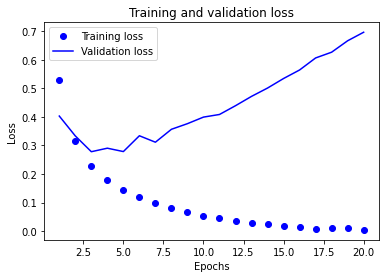

In [127]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

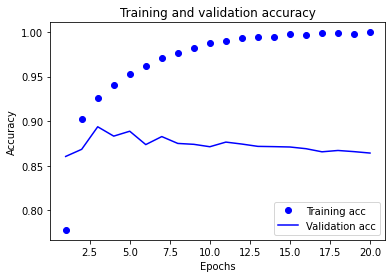

In [128]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Training loss decreases with every epoch, and the training accuracy increases with every epoch. This is a sign of overfitting. Let's limit the network to 4 epochs and see how it performs.

In [129]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 2s 85us/step - loss: 0.4407 - accuracy: 0.8231
Epoch 2/4
25000/25000 [==============================] - 2s 83us/step - loss: 0.2494 - accuracy: 0.9143
Epoch 3/4
25000/25000 [==============================] - 2s 83us/step - loss: 0.1957 - accuracy: 0.9300
Epoch 4/4
25000/25000 [==============================] - 2s 62us/step


In [130]:
results

[0.29674342153549194, 0.8836399912834167]

The final results acheive an accuracy of 86%.

#3.4.5 Using a trained network to generate predictions on new data

You can generate the likelihood of reviews being positive by using the *predict* method:

In [131]:
model.predict(x_test)

array([[0.18791917],
       [0.9996582 ],
       [0.8773444 ],
       ...,
       [0.15879169],
       [0.09051996],
       [0.63811547]], dtype=float32)

#3.4.6 Further experiments

fill in later

#3.4.7 Wrapping up

Fill in later

#3.5 Classifying newswires: a multiclass classification example

In the previous section, you saw how to classify vector inputs into two mutually exclusive classes using a densely connected neural network. But what happens when you have more than two classes?

In this section, you'll build a network to classify Reuters newswires into 46 mutually exclusive topics. Because you have many classes, this problem is an instance of *multiclass classification*; and because each data point should be classified into only one category, the problem is more specifically an instance of *single-label, multiclass classification*. If each data point could belong to multiple categories, you'd be facing a *multilabel, multiclass classification* problem.

#3.5.1 The Reuters dataset

You'll work with the *Reuters* dataset, a set of short newswires and their topics, published by Reuters in 1986. It's a simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

In [132]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

I am restricting the the data to the 10,000 most frequently occurring words found in the data with the argument num_words=10000.

In [133]:
len(train_data)

8982

In [134]:
len(test_data)

2246

Each example is a list of integers:

In [135]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [136]:
word_index = reuters.get_word_index()
reverse_word_index = dict([value, key ] for (key, value) in word_index.items())
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [137]:
train_labels[10]

3

#3.5.2 Preparing the data

We can use the same code snippet to vectorize the data.

In [138]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In terms of vectorizing the labels we will use one-hot encoding. One-hot encoding is a widely used for categorical data, also called *categorical encoding*. Here's an example:

In [139]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(train_labels)

Keras has this functionality built in:

```
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

```

#3.5.3 Building your network

This topic-classification problem is similar to our previous classification problem. The new constraint here: the number of output classes has gone from 2 to 46. The dimensionality of the output space is much larger.

As we have a larger number of output classes we need to up the dimensionality of our Dense layers so we don't lose relevant information between layers. We will go with 64 units.

In [140]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


* The last layer of the network has a size of 46. For each input sample, the network will output a 46-dimensional vector. Each entry will encode a different output class.
* The softmax activation will output a *probability distribution* over the 46 different output classes-for every input sample. The 46 scores will sum to 1.

The best loss function to use in this case is *categorical_crossentropy* It measures the distance between two probability distributions: here, between the probability distribution output by the network and the true distribution of the labels. 

In [141]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#3.5.4 Validating your approach

We set apart 1,000 sample in the training data as a validation set.

In [142]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now, train the network for 20 iterations or epochs.

In [143]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 139us/step - loss: 2.5092 - accuracy: 0.5355 - val_loss: 1.6585 - val_accuracy: 0.6520
Epoch 2/20
7982/7982 [==============================] - 1s 129us/step - loss: 1.3804 - accuracy: 0.7091 - val_loss: 1.2815 - val_accuracy: 0.7110
Epoch 3/20
7982/7982 [==============================] - 1s 128us/step - loss: 1.0316 - accuracy: 0.7742 - val_loss: 1.1203 - val_accuracy: 0.7630
Epoch 4/20
7982/7982 [==============================] - 1s 128us/step - loss: 0.8132 - accuracy: 0.8240 - val_loss: 1.0176 - val_accuracy: 0.7850
Epoch 5/20
7982/7982 [==============================] - 1s 128us/step - loss: 0.6474 - accuracy: 0.8611 - val_loss: 0.9571 - val_accuracy: 0.7970
Epoch 6/20
7982/7982 [==============================] - 1s 128us/step - loss: 0.5159 - accuracy: 0.8900 - val_loss: 0.9431 - val_accuracy: 0.7990
Epoch 7/20
7982/7982 [==============================] - 1s 126us/step - loss

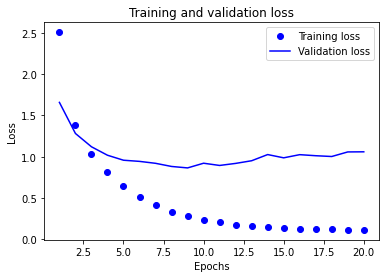

In [144]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()

plt.show()

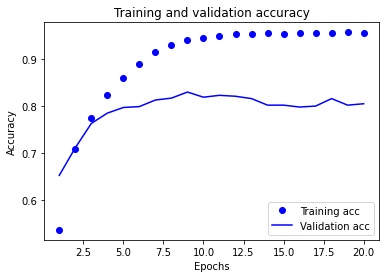

In [145]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

After nine epochs our network begins to over fit.

In [146]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 139us/step - loss: 2.4644 - accuracy: 0.5313 - val_loss: 1.6168 - val_accuracy: 0.6400
Epoch 2/9
7982/7982 [==============================] - 1s 132us/step - loss: 1.3535 - accuracy: 0.7080 - val_loss: 1.2813 - val_accuracy: 0.7100
Epoch 3/9
7982/7982 [==============================] - 1s 130us/step - loss: 1.0251 - accuracy: 0.7721 - val_loss: 1.1029 - val_accuracy: 0.7540
Epoch 4/9
7982/7982 [==============================] - 1s 131us/step - loss: 0.8134 - accuracy: 0.8264 - val_loss: 1.0268 - val_accuracy: 0.7820
Epoch 5/9
7982/7982 [==============================] - 1s 129us/step - loss: 0.6450 - accuracy: 0.8619 - val_loss: 0.9620 - val_accuracy: 0.7900
Epoch 6/9
7982/7982 [==============================] - 1s 129us/step - loss: 0.5193 - accuracy: 0.8910 - val_loss: 0.9322 - val_accuracy: 0.8110
Epoch 7/9
7982/7982 [==============================] - 1s 131us/step - loss: 0.416

ValueError: ignored

In [147]:
x_test.shape

(2246, 10000)

In [148]:
one_hot_test_labels.shape

(8982, 46)